(propensity_score_matching)=
# Bayesian propensity score matching

:::{post} July, 2022
:tags: causal inference, quasi experimental design, regression, propensity score, logistic regression
:category: intermediate
:author: Benjamin T. Vincent
:::

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc as pm
import seaborn as sns

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Introduction
[Propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching) is an approach to making causal inferences in non-expermental settings. You may have a control and a treatment group, but allocation to the treatment group was _not_ randomised. So there may be some [confounding variables](https://en.wikipedia.org/wiki/Confounding).

This can happen for a variety of reasons: it is not ethical to assign people to smoke cigaretes, you cannot reassign someone's gender, and it is not always possible to fully randomise who sees an advertisement for your product or service.

This notebook is loosely based upon the excellent video [An intuitive introduction to Propensity Score Matching](https://www.youtube.com/watch?v=ACVyPp1Fy6Y) by Doug McKee.

## Data

In [3]:
df = pd.DataFrame(
    {
        "treatment": [1, 1, 1, 1, 0, 0, 0, 0, 0],
        "infant_mortality": [10, 15, 22, 19, 25, 19, 4, 8, 6],
        "docs_per_capita": [0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.04, 0.05, 0.04],
        "poverty_rate": [0.5, 0.6, 0.7, 0.6, 0.6, 0.5, 0.1, 0.3, 0.2],
    }
)
df

,treatment,infant_mortality,docs_per_capita,poverty_rate
0,1,10,0.01,0.5
1,1,15,0.02,0.6
2,1,22,0.01,0.7
3,1,19,0.02,0.6
4,0,25,0.01,0.6
5,0,19,0.02,0.5
6,0,4,0.04,0.1
7,0,8,0.05,0.3
8,0,6,0.04,0.2


## Simple (wrong) causal explanation

The simplest approach we could take is to assume that infant mortality is causally influenced by the treatement, and the treatment alone. This causal DAG (see below) would suggest that we should simply look for differences in infant morality is different depending upon the treatment - so a simple linear model such as `infant_mortality ~ treatment`.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


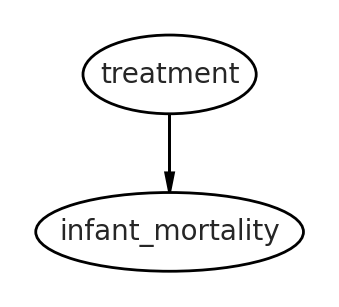

In [4]:
pgm = daft.PGM()
pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant_mortality", 0, -1, aspect=3.4)
pgm.add_edge("t", "im")
pgm.render(dpi=100);

### Differences in outcome by treatment
We could just look at the differences in infant mortality, split by treatment:

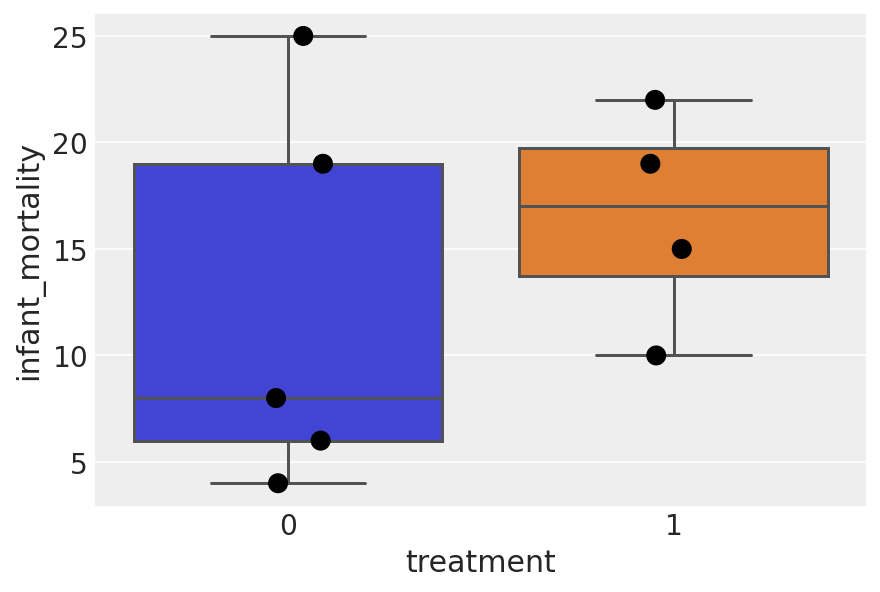

In [5]:
sns.boxplot(
    x="treatment",
    y="infant_mortality",
    data=df,
)

sns.stripplot(
    x="treatment",
    y="infant_mortality",
    data=df,
    size=10,
    color="k",
);

### Bayesian estimate of treatment effect

In [6]:
with pm.Model() as bad_model:
    control_mean = pm.Normal("control_mean", 10, 5)
    treatment_effect = pm.Normal("treatment_effect", 0, 5)
    mu = control_mean + df.treatment.to_numpy() * treatment_effect
    sigma = pm.HalfNormal("sigma", 2)
    pm.Normal("obs", mu, sigma, observed=df["infant_mortality"].to_numpy())

    bad_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_mean, treatment_effect, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


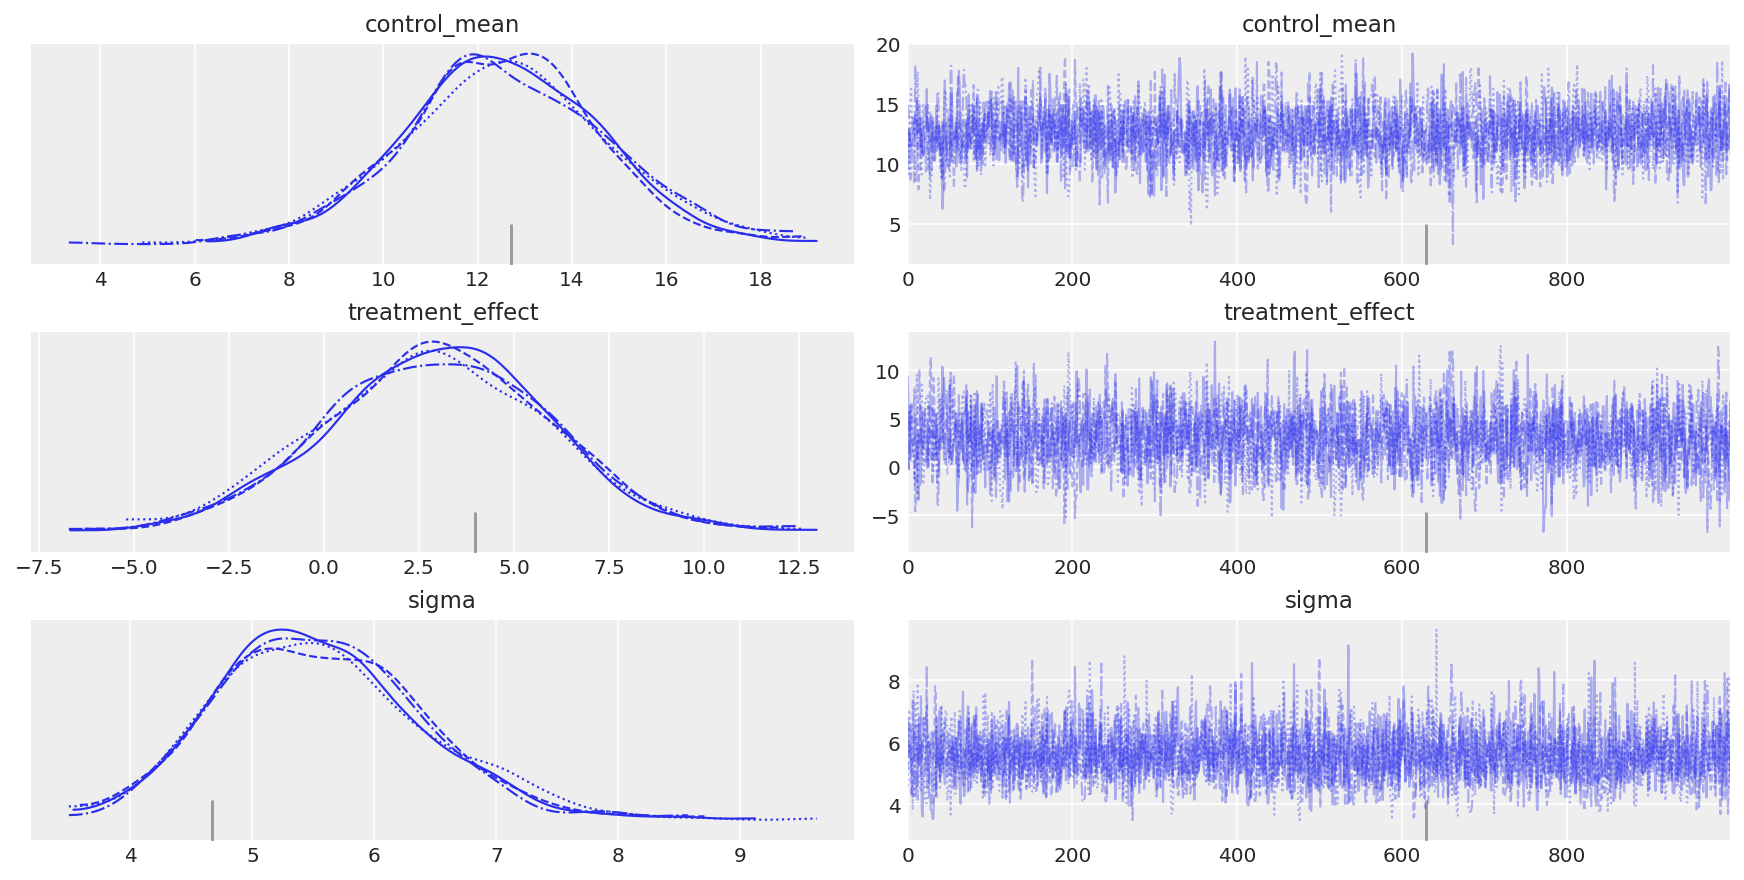

In [7]:
az.plot_trace(bad_idata);

So let's look at our posterior distribution over the treatment effect. Is it different from zero, and does it indicate a good outcome by showing a negative treatment effect (i.e. a lowering of infant mortality from the treatment).

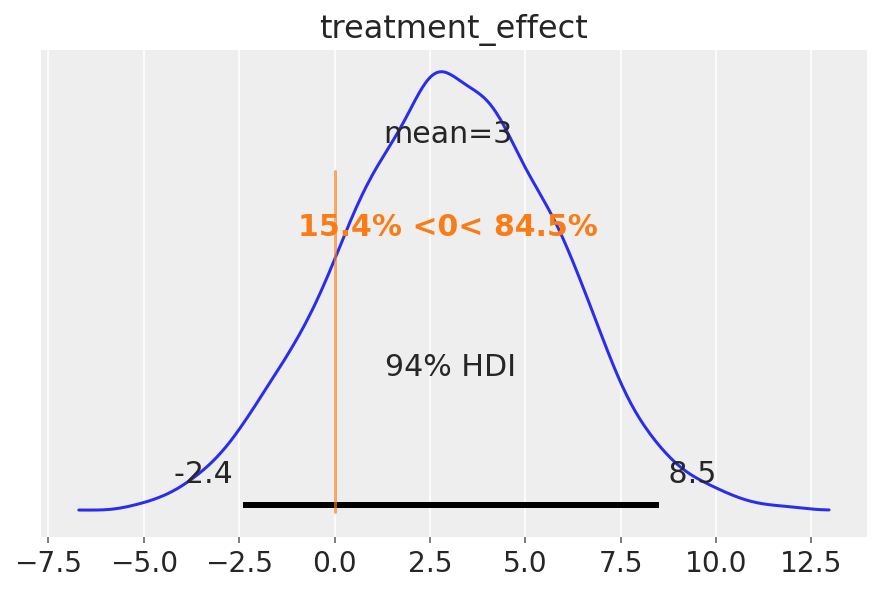

In [8]:
az.plot_posterior(bad_idata, var_names="treatment_effect", ref_val=0);

So this simple approach leaves us with quite a bit of uncertainty about the treatment effect size. Having said that, the posterior mean is positive (and about 78% of the posterior mass is positive), which means that we would very tentatively conclude that our intervention _increases_ infant mortality.

This would be unexpected, and also wrong in this example.

What else could we do?

If we had access to measures of infant mortality pre-treatment, then we could use a [differences in differences](https://en.wikipedia.org/wiki/Difference_in_differences) approach. But in this case, we do not have that data.



## Counfounders
Instead, we do have measures (conducted pre-treatment) of other properties of regions which may have influenced how they were assigned to the treatment or control condition.

We know in this case, our treatment was _not_ randomly assigned. Instead, we suspect through careful understanding of the particular problem, that regions with lower doctors per capita and higher poverty rates were more likely to be assigned to the treatment group. 

This would be in line with the heuristic of compassionate allocation of treatment to regions which needed it most. Although this would be statistically frustrating as it means we don't have random assignment.

All this means that our treatment and control groups are unequal in terms of their characteristics, as we can see in the plot below.

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


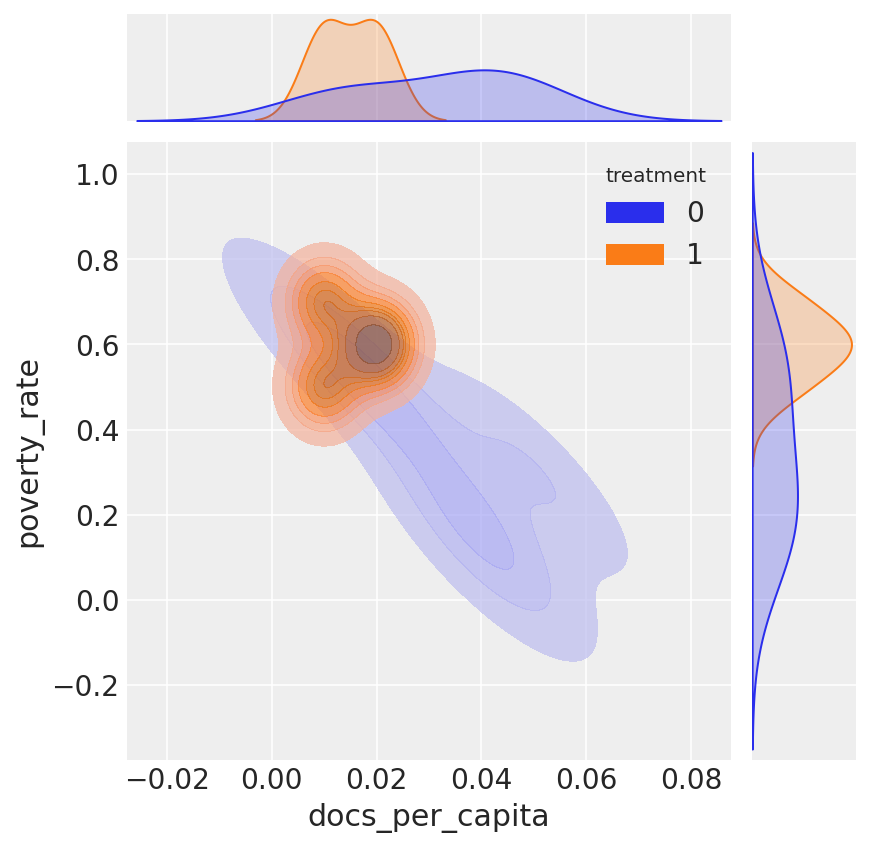

In [9]:
sns.jointplot(
    x="docs_per_capita",
    y="poverty_rate",
    hue="treatment",
    data=df,
    kind='kde', fill=True, alpha=0.7
);

**NOTE:** If there was a sharp threshold in the characteristics of the regions being assigned to the treatment of control group, then we could consider analysing the data with the regression discontinuity design framework which we have covered here: {doc}`regression_discontinuity`.

## Improved causal explanation

We can however now refine our causal explanation of the data to incorporate these confounding variables. These can be summarised in the following DAG:

/Users/benjamv/mambaforge/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


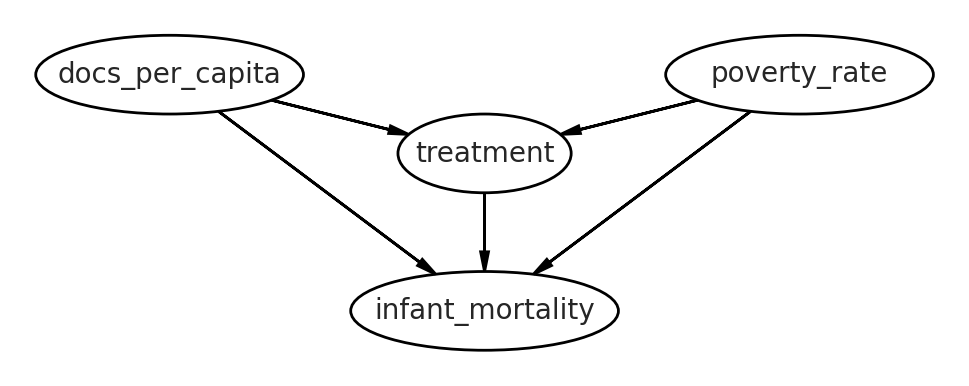

In [10]:
pgm = daft.PGM()

pgm.add_node("t", "treatment", 0, 0, aspect=2.2)
pgm.add_node("im", "infant_mortality", 0, -1, aspect=3.4)
pgm.add_node("docs", "docs_per_capita", -2, 0.5, aspect=3.4)
pgm.add_node("pov", "poverty_rate", 2, 0.5, aspect=3.4)

pgm.add_edge("t", "im")
pgm.add_edge("docs", "t")
pgm.add_edge("docs", "im")
pgm.add_edge("pov", "t")
pgm.add_edge("pov", "im")

pgm.render(dpi=100);

So in words what the DAG says is:
- exposure to treatment will causally inflence infant mortality
- but the number of doctors per captia causally influences both assignment to the treatment group and infant mortality levels
- and the poverty rate causally influences both the assignment to the treatment group and the infant mortality.

So we have doctors per capita and poverty rates confounding the treatment $\rightarrow$ infant mortality relationship.

There are different approaches we could take here, but our focus here is on propensity score matching.

## Step 1: Calculate propensity score
In this section we will build a PyMC logistic regression model of the propensity. That is, the probability of inclusion in the treatment group.

In [11]:
y, X = patsy.dmatrices("treatment ~ docs_per_capita * poverty_rate", df)
labels = X.design_info.column_names
y, X = np.squeeze(np.asarray(y)), np.asarray(X)

COORDS = {"coeffs": labels, "obs": list(df.index)}

with pm.Model(coords=COORDS) as propensity_model:
    beta = pm.Normal("beta", 0, 1, dims="coeffs")
    propensity_score = pm.Deterministic(
        "propensity score", pm.math.invlogit(pm.math.dot(X, beta)), dims="obs"
    )
    pm.Bernoulli("infant_mortality", p=propensity_score, observed=y, dims="obs")
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


We can optionally inspect the traces, but there are no sampling issues apparent.

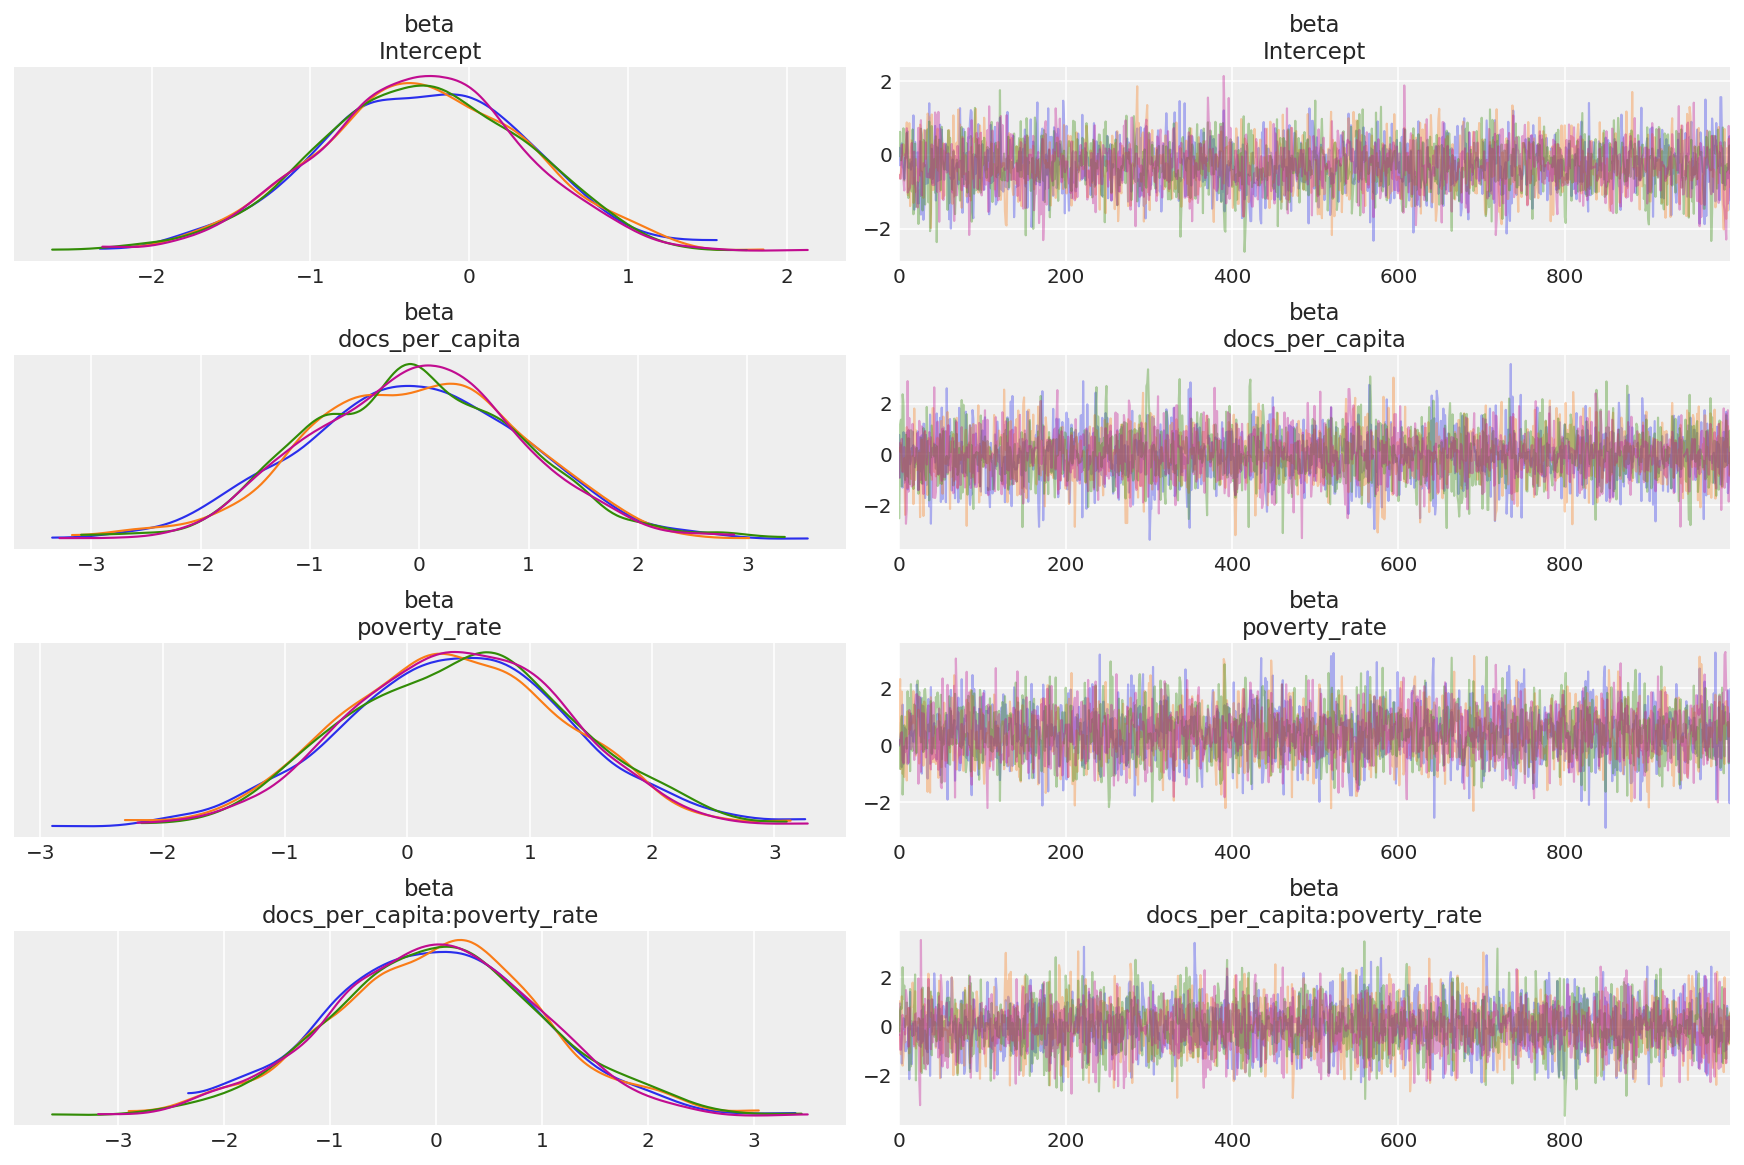

In [12]:
az.plot_trace(idata, compact=False, var_names="~propensity score");

And we can get a quick insight into the propensity scores by plotting the distribution of posterior mean propensity scores, split by treatment. This is good as there is some overlap in the propensity scores in both groups.

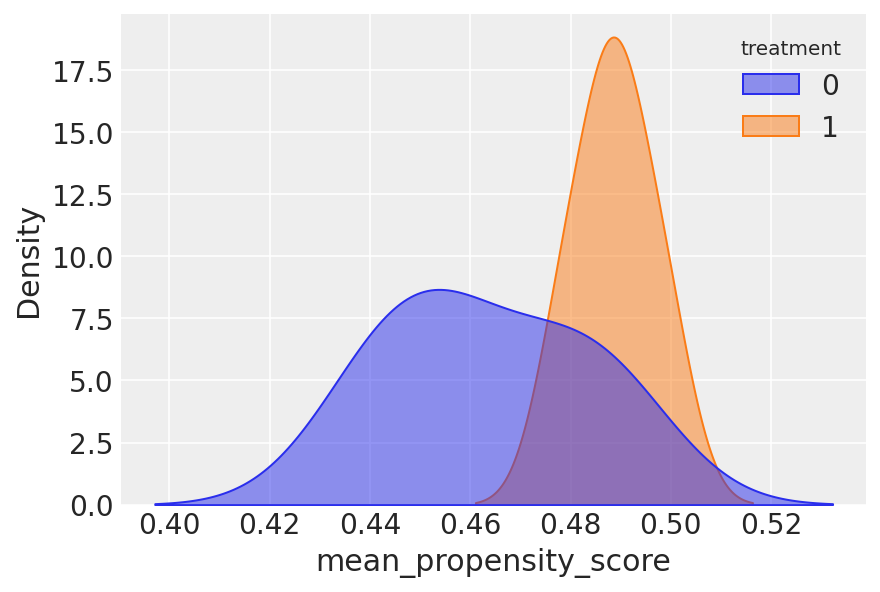

In [13]:
df["mean_propensity_score"] = idata.posterior["propensity score"].mean(dim=["chain", "draw"])

sns.kdeplot(
    data=df, x="mean_propensity_score", hue="treatment", clip=(0, 1), fill=True, alpha=0.5
);

## Step 2: Matching
The next step is to construct a "synthetic control group" with the following algorithm:

> for each unit in the treatment group, find a unit in the control group with the most similar propensity score.

The logic of this is that we are trying to build an artifical control group which is more similar to the treatment group in terms of the confounders than the raw control group.

There are many different algorithms used for matching, and some are best in different situations. We are going to pick one at random and go with finding the closest value and use sampling with replacement.

In [14]:
def find_nearest(array, value):
    # array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [15]:
def match(prop_treatment_list, prop_control_list):
    synth_control_idx = []
    for i, prop_treatment in enumerate(prop_treatment_list):
        # do the matching
        val, idx = find_nearest(prop_control_list, prop_treatment)
        synth_control_idx.append(idx)
    return synth_control_idx

In [16]:

# print(n_obs, n_samples)

# treatment_set = df['treatment']==1

In [17]:
# extract the MCMC samples of propensity scores
prop_scores = idata.posterior['propensity score'].stack(sample=['chain', 'draw']).data

# calculate quantities which are constant over samples
outcome_varname = 'infant_mortality'
mean_of_treatment_group = np.mean(df[outcome_varname][df['treatment']==1])
treatment_set = df['treatment']==1
n_obs, n_samples = prop_scores.shape

treatment_effect = []

for sample in range(n_samples):
    # extract propensity scores for treatment and control units
    prop_treatment_list = prop_scores[treatment_set, sample]
    prop_control_list = prop_scores[~treatment_set, sample]
    
    # do propensity score matching
    synth_control_idx = match(prop_treatment_list, prop_control_list)
        
    # calculate the treatment effect between treatment and the matched control group
    synthetic_control_outcome_values = df.loc[synth_control_idx, outcome_varname]
    mean_of_matched_control_group = np.mean(synthetic_control_outcome_values)
    treatment_effect.append(mean_of_matched_control_group - mean_of_treatment_group)
    
treatment_effect = np.array(treatment_effect)

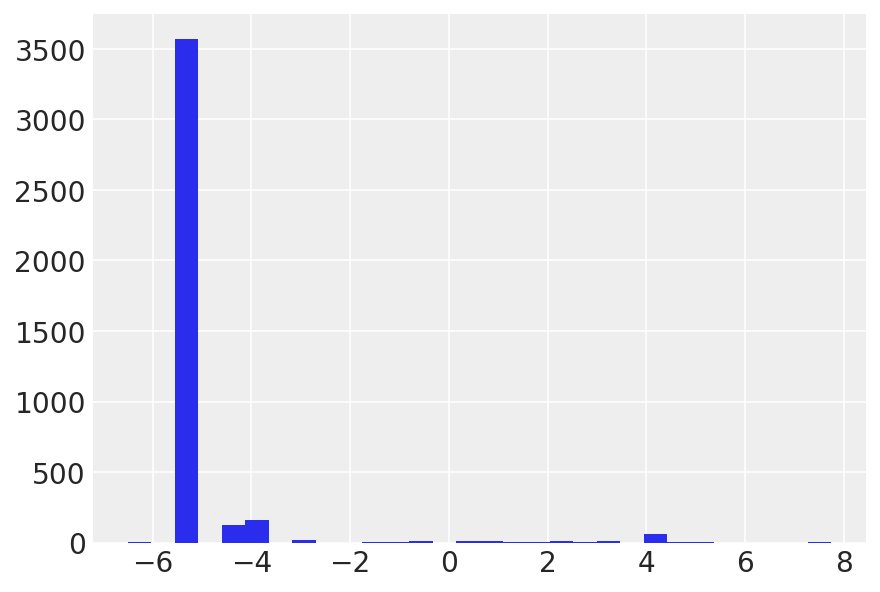

In [18]:
plt.hist(treatment_effect, bins=30);

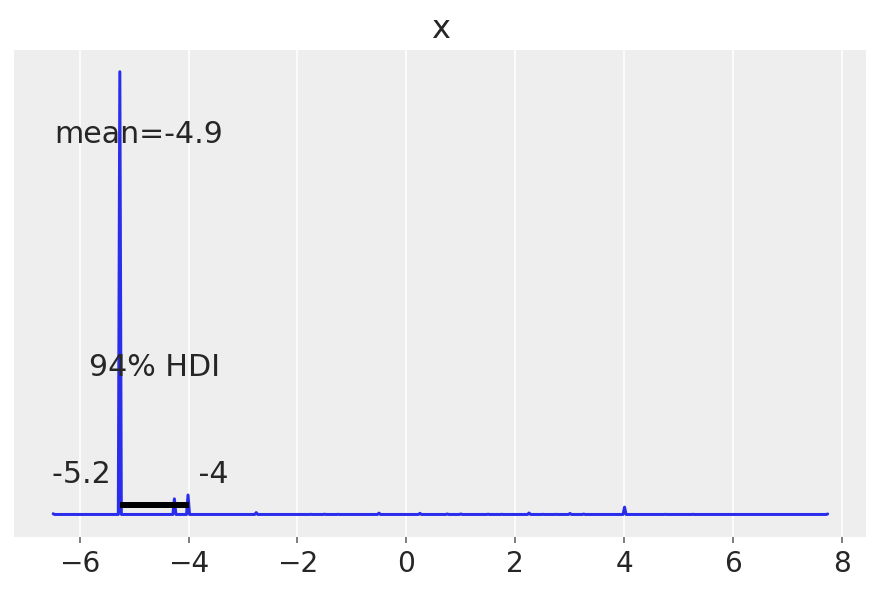

In [19]:
az.plot_posterior(treatment_effect);

## Step 3: Matching quality evaluation

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2022.

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sun Jul 17 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

aesara: 2.7.3
aeppl : 0.0.31
xarray: 2022.3.0

arviz     : 0.12.1
matplotlib: 3.5.2
pandas    : 1.4.3
seaborn   : 0.11.2
pymc      : 4.0.1
daft      : 0.1.2
numpy     : 1.23.0
patsy     : 0.5.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::